# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [14]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [9]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

### Perform some basic filtering

In [10]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [11]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [12]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


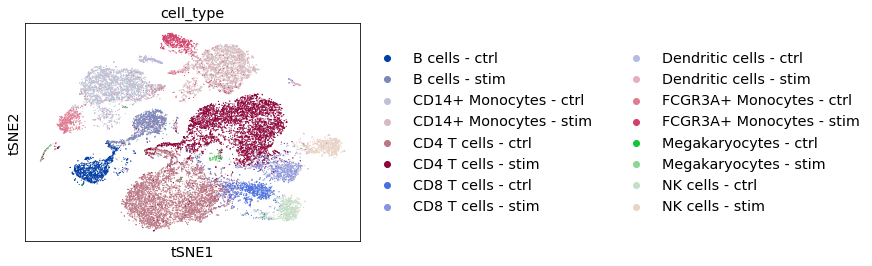

In [15]:
sc.pl.tsne(adata, color='cell_type')

In [16]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [17]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


### Some useful functions

In [19]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### Select immune genes using GO annotations

In [19]:
go_annotations = pd.read_csv(data_path + '../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [20]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [21]:
genes_of_interest = list(set(adata.var.index) & set(immune_genes))

In [ ]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(genes_of_interest, f)

### Observed $\mu$-$CV^{2}$ Relationship

In [20]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [21]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: FCGR3A+ Monocytes - stim


In [22]:
estimator.estimate_parameters()

In [23]:
estimator.noise_level

0.14298063266117056

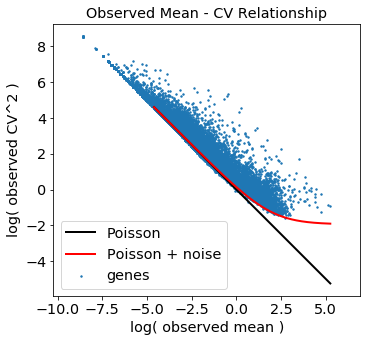

In [24]:
estimator.plot_cv_mean_curve()
#plt.savefig(data_path + 'figures/observed_cv_vs_mean.png', bbox_inches='tight')

### Residual variance

In [23]:
estimator.estimate_parameters()

In [24]:
est_mean = np.concatenate([estimator.estimated_central_moments[ct]['first'] for ct in estimator.groups])
est_var = np.concatenate([estimator.estimated_central_moments[ct]['second'] for ct in estimator.groups])
est_disp = est_var/est_mean
est_cv = est_var/est_mean**2

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.03336931]


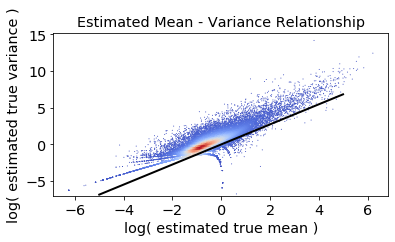

In [28]:
plt.figure(figsize=(6, 3))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var),
    s=1, 
    cmap='coolwarm')
x_fit = np.arange(-5, 5, 0.01)
y_fit = x_fit*estimator.mean_var_slope
plt.plot(x_fit, y_fit, color='k', lw=2)
plt.ylim(-7,)
plt.title('Estimated Mean - Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true variance )')
plt.savefig(data_path + 'figures/mean_vs_var.png', bbox_inches='tight')

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.0333693 ]


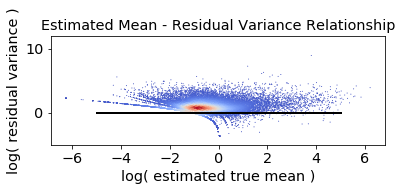

In [29]:
plt.figure(figsize=(6, 2))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var) - estimator.mean_var_slope*np.log(est_mean),
    s=1, 
    cmap='coolwarm')
plt.plot([-5, 5], np.array([0, 0]), color='k', lw=2)
plt.ylim(-5,12)
plt.title('Estimated Mean - Residual Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( residual variance )')
plt.savefig(data_path + 'figures/mean_vs_res_var.png', bbox_inches='tight')

### CD4 T cell analysis

In [150]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata[adata.obs['cell'] == 'CD4 T cells', :].copy(), 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [151]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: CD4 T cells - stim


In [152]:
estimator.estimate_parameters()

In [153]:
ct = 'CD4 T cells'

In [155]:
%%time
imp.reload(scme)
estimator.compute_confidence_intervals_1d(
    groups=[ct + ' - ctrl', ct + ' - stim'],
    groups_to_compare=[(ct + ' - ctrl', ct + ' - stim')])

Gamma RVs generated..
CPU times: user 1min 50s, sys: 450 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
imp.reload(utils)
upregulated_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='mean',
    direction='increase',
    sig=0.1, 
    num_genes=1000)

In [375]:
inc_var_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='variance',
    direction='increase',
    sig=0.15, 
    num_genes=1000)
dec_var_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='variance',
    direction='decrease',
    sig=0.15, 
    num_genes=1000)

In [397]:
up_inc_var = upregulated_genes\
    .merge(inc_var_genes, on='gene', how='inner', suffixes=('_de', '_dv'))
up_dec_var = upregulated_genes\
    .merge(dec_var_genes, on='gene', how='inner', suffixes=('_de', '_dv'))

In [398]:
up_inc_var

,pval_de,fdr_de,effect_size_de,gene,rank_de,pval_dv,fdr_dv,effect_size_dv,rank_dv
0,1.623588e-07,0.000008,0.492016,CCR7,23,3.799620e-03,0.120879,0.511030,29
1,1.878842e-07,0.000008,3.092909,TNFSF10,26,4.091971e-05,0.004042,1.119020,13
2,6.993094e-07,0.000015,0.381371,SRM,50,3.799620e-03,0.120879,0.703132,28
3,7.704338e-07,0.000016,0.990211,IRF1,51,5.599440e-03,0.143975,0.630926,37
4,9.914582e-07,0.000018,1.552170,PRF1,56,2.037870e-05,0.002493,0.990799,10
5,1.112283e-06,0.000019,3.192419,IFI27,61,3.723356e-07,0.000116,1.332213,4
6,1.155896e-06,0.000019,3.102690,IFITM3,62,2.541243e-07,0.000108,0.929113,2
7,1.281356e-06,0.000019,0.483148,ZC3HAV1,65,7.999200e-04,0.041707,0.844556,19
8,2.082402e-06,0.000024,0.168159,HSPA5,87,2.997340e-05,0.003309,1.184036,11
9,7.544188e-06,0.000052,0.577428,FUNDC1,133,5.399460e-03,0.143975,1.749850,36


In [399]:
up_dec_var

,pval_de,fdr_de,effect_size_de,gene,rank_de,pval_dv,fdr_dv,effect_size_dv,rank_dv
0,1.233110e-08,0.000003,0.767666,GIMAP4,6,1.291838e-05,0.002425,0.839443,3
1,5.148650e-08,0.000006,2.632958,IFI44,13,1.461069e-04,0.010157,1.550909,11
2,1.644337e-07,0.000008,0.140271,TRAT1,25,9.999000e-04,0.049390,0.881253,19
3,3.258228e-07,0.000010,3.307848,IFI44L,30,1.549690e-05,0.002489,1.865907,4
4,6.082355e-07,0.000014,0.763173,SELL,43,7.999200e-04,0.041707,0.560770,17
5,2.087332e-06,0.000024,0.262437,CYCS,86,9.999000e-04,0.049390,1.037301,18
6,2.901903e-06,0.000029,0.868869,ARHGAP25,95,1.599840e-03,0.066731,0.928255,22
7,3.389279e-06,0.000032,1.497907,PARP11,100,1.821716e-05,0.002489,0.950234,5
8,7.237614e-06,0.000051,4.624475,IFIT1,131,1.999800e-04,0.012444,3.780797,13
9,1.784071e-05,0.000097,4.607336,IFIT3,160,1.999800e-04,0.012444,4.622662,12


## Effect of interferon stimulation across cell types

### Read 1D Hypothesis test results and confidence intervals

Make sure that p values are well calibrated.

In [25]:
def get_key(ct):
    return (ct + ' - ctrl', ct + ' - stim')

In [22]:
with open(data_path + 'stim_effect_1d_params.pkl', 'rb') as f:
    parameter_dict = pkl.load(f)
with open(data_path + 'stim_effect_ci_1d.pkl', 'rb') as f:
    ci_dict = pkl.load(f)
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    test_dict = pkl.load(f)

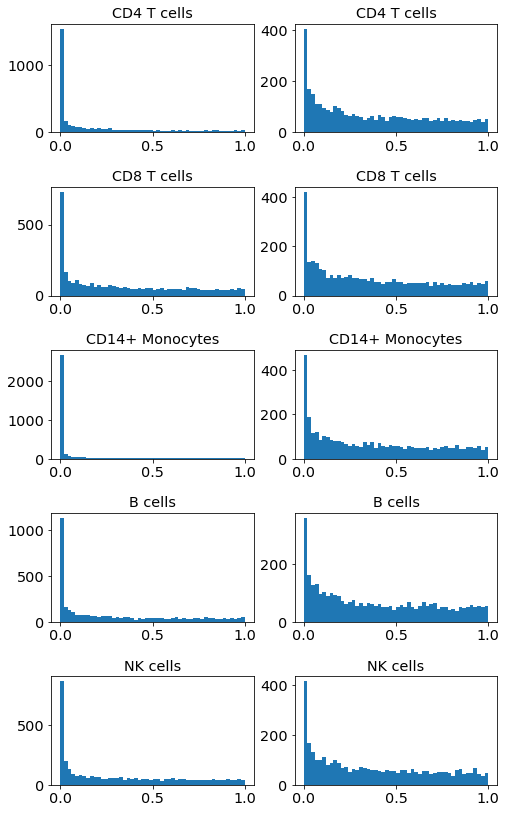

In [54]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells']):
    
    plt.subplot(5, 2, 2*idx+1);
    plt.hist(test_dict[get_key(ct)]['de_pval'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(5, 2, 2*idx+2);
    plt.hist(test_dict[get_key(ct)]['dv_pval'], bins=50);
    plt.title('{}'.format(ct))
plt.savefig('de_dv_calibration.pdf', bbox_inches='tight')

### Direct ISRE/GAS genes

Compared to all genes are that upregulated during IFN-B stimulation, genes with ISRE/GAS binding sites are more likely to decrease in variability.

In [132]:
fname = 'frontiers_isre_gas_genes.txt'
all_isre_gas_genes = pd.read_csv(fname, sep='\n', header=None)[0].values.tolist()

In [133]:
isre_gas_genes = []
for gene in adata.var.index:
    
    is_isre_gas = False
    for candidate in all_isre_gas_genes:
        if candidate in gene:
            is_isre_gas = True
    if is_isre_gas:
        isre_gas_genes.append(gene)

In [134]:
isre_gas_idxs = np.where(np.isin(adata.var.index, isre_gas_genes))[0]

In [252]:
ct_dfs = []
for ct in ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']:
    
    # Get upregulated genes
    upreg_genes = utils.get_differential_genes(
        gene_list=adata.var.index.tolist(),
        hypothesis_test_dict=test_dict,
        group_1 = get_key(ct)[0],
        group_2 = get_key(ct)[1],
        which='mean',
        direction='increase',
        sig=0.05,
        num_genes=5000
        )['gene'].tolist()
    upreg_genes = list(set(upreg_genes) - set(isre_gas_genes))
    upreg_gene_idxs = np.where(np.isin(adata.var.index, upreg_genes))[0]
    
    dv_diffs_isre_gas = test_dict[get_key(ct)]['dv_diff'][isre_gas_idxs]
    dv_fdr_isre_gas = test_dict[get_key(ct)]['dv_fdr'][isre_gas_idxs]
    dv_diffs_upreg = test_dict[get_key(ct)]['dv_diff'][upreg_gene_idxs]
    dv_fdr_upreg = test_dict[get_key(ct)]['dv_fdr'][upreg_gene_idxs]
    
    dv_diffs_isre_gas = dv_diffs_isre_gas#[dv_fdr_isre_gas < 1]
    dv_diffs_upreg = dv_diffs_upreg#[dv_fdr_upreg < 1]
    
    isre_gas_df = pd.DataFrame()
    isre_gas_df['dv_diff'] = dv_diffs_isre_gas
    isre_gas_df['dv_fdr'] = dv_fdr_isre_gas
    isre_gas_df['type'] = 'ISRE/GAS'
    
    upreg_df = pd.DataFrame()
    upreg_df['dv_diff'] = dv_diffs_upreg
    upreg_df['dv_fdr'] = dv_fdr_upreg
    upreg_df['type'] = 'upregulated'
    
    combined_df = pd.concat([isre_gas_df, upreg_df])
    combined_df['cell_type'] = ct
    ct_dfs.append(combined_df.copy())
    
    print(ct, stats.ttest_ind(dv_diffs_isre_gas, dv_diffs_upreg))
isre_gas_comparison_df = pd.concat(ct_dfs)
#cts = ['CD4 T cells', 'CD8 T cells', 'NK cells', 'B cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes']

#isre_gas_comparison_df = isre_gas_comparison_df[isre_gas_comparison_df['cell_type'].isin(cts)]

CD4 T cells Ttest_indResult(statistic=-4.670680785071228, pvalue=3.526004407661371e-06)
CD14+ Monocytes Ttest_indResult(statistic=nan, pvalue=nan)
FCGR3A+ Monocytes Ttest_indResult(statistic=-3.8213006219939807, pvalue=0.00014475071139487334)
NK cells Ttest_indResult(statistic=-2.4989508053480334, pvalue=0.012828210628054169)
CD8 T cells Ttest_indResult(statistic=-0.44978541296302216, pvalue=0.6531137875923599)
B cells Ttest_indResult(statistic=-0.34849099923356636, pvalue=0.7276050693239242)


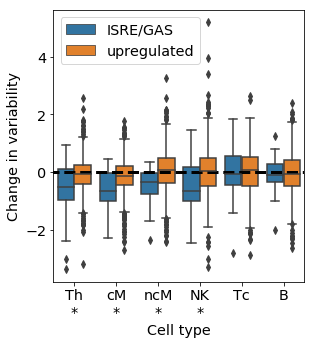

In [248]:
plt.figure(figsize=(4.5, 5))
sns.boxplot(
    x='cell_type', y='dv_diff', hue='type',
    data=isre_gas_comparison_df)
plt.plot([-1, 6], [0, 0], '--', lw=3, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th\n*', 'cM\n*', 'ncM\n*', 'NK\n*', 'Tc', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper left')
plt.savefig('isre_gas_dv.pdf', bbox_inches='tight')

### Expression changes across CT for a gene

In [20]:
adata.var['num'] = np.arange(adata.shape[1])

In [21]:
adata.var.loc['IFI6']

gene_ids    ENSG00000126709
n_counts    59361          
n_cells     2457           
num         66             
Name: IFI6, dtype: object

In [32]:
parameter_dict['CD4 T cells' + ' - ctrl']

{'mean': array([0.11641452, 0.448196  , 0.8653453 , ..., 0.56849104, 0.2658132 ,
        0.40745094], dtype=float32),
 'log_mean': array([-2.150598  , -0.8025247 , -0.14462666, ..., -0.56476974,
        -1.3249614 , -0.8978347 ], dtype=float32),
 'residual_var': array([3.75603655, 2.0069145 , 2.94908531, ..., 2.53497887, 1.12987436,
        1.90244249]),
 'log_residual_var': array([1.32336429, 0.69659847, 1.08149506, ..., 0.9301853 , 0.12210644,
        0.64313858])}

In [33]:
def plot_exp_changes_across_ct(gene, parameter_dict, ci_dict, barwidth=0.3):
    
    plt.figure(figsize=(11, 6))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = adata.obs['cell'].drop_duplicates()
    
    labels = adata.obs['cell'].drop_duplicates()
    labels = [label.replace(' ', '\n') for label in labels]
    labels[-2] = 'Megaka\nryocytes'
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([parameter_dict[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([parameter_dict[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([ci_dict[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([ci_dict[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([parameter_dict[group + ' - ctrl']['residual_var'][gene_idx] for group in groups])
    stim_vars = np.array([parameter_dict[group + ' - stim']['residual_var'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([ci_dict[group + ' - ctrl']['log1p_residual_var'][gene_idx] for group in groups])
    stim_vars_ci = np.array([ci_dict[group + ' - stim']['log1p_residual_var'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 1)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Log(res.variance+1)')

In [35]:
across_ct_genes = ['TNFSF10', 'IFI44L', 'TRIM22']

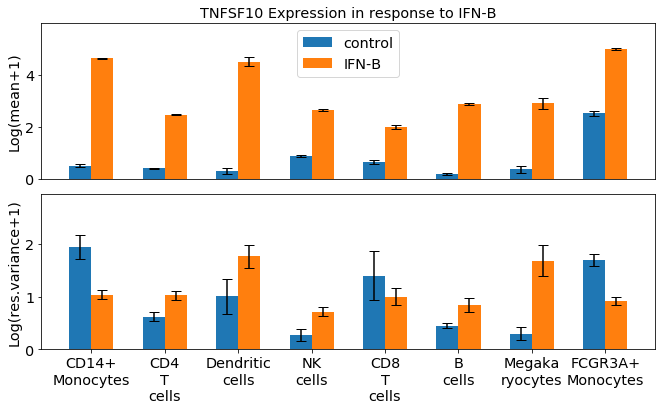

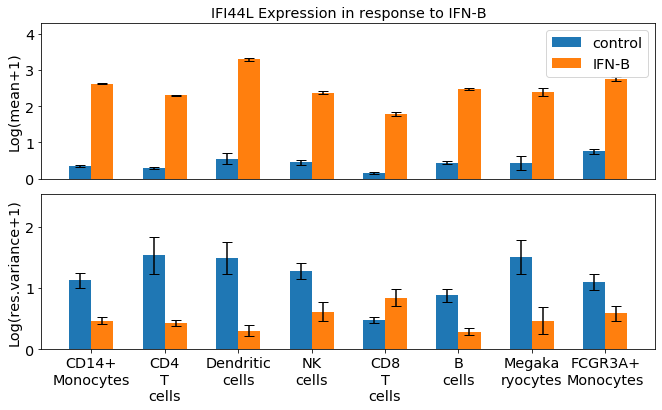

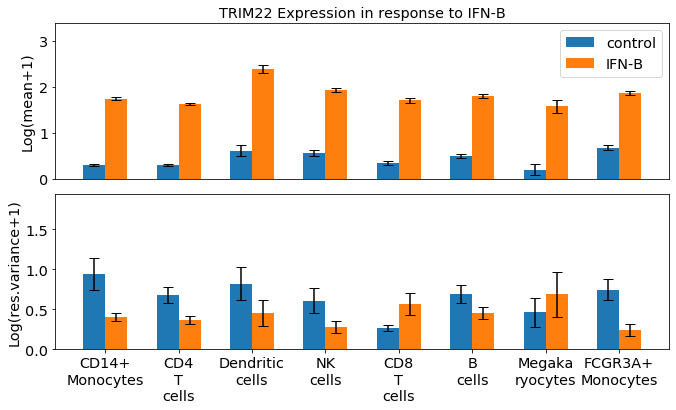

In [36]:
for gene in across_ct_genes:
    try:
        plot_exp_changes_across_ct(gene, parameter_dict, ci_dict)
    except:
        continue
    plt.savefig(data_path + 'figures/{}_across_ct.pdf'.format(gene), bbox_inches='tight')

### Expression changes across different genes for a CT

In [1]:
def plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3):

    plt.figure(figsize=(len(genes)*1.5, 7))
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([parameter_dict[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([parameter_dict[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([ci_dict[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([parameter_dict[ct + ' - ctrl']['residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([parameter_dict[ct + ' - stim']['residual_var'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([ci_dict[ct + ' - stim']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    plt.title('Expression changes in {}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1.4)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Log(res.variance+1)')

In [2]:
#genes_1 = ['PTCD3', 'CDK12', 'RAB3GAP1', 'FAS', 'SETX']
genes_1 = ['HSPA5', 'KDM5A', 'FUNDC1', 'SELL', 'TRAT1']
# both sig, only var sig, both sig, both sig, both sig, only var

In [3]:
genes_2 = ['IFIT1', 'IFIT2', 'IFIT3', 'IFITM3', 'IFIT5', 'IFI27']

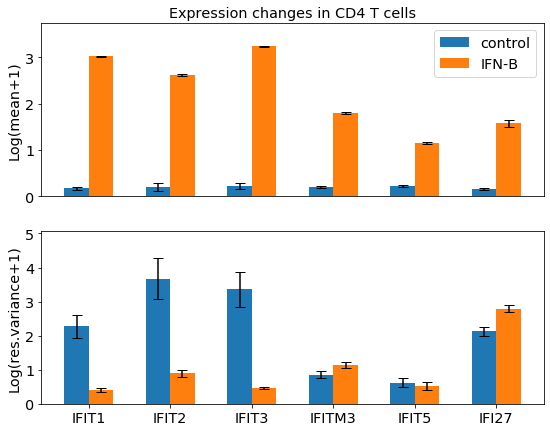

In [44]:
plot_exp_across_genes(genes_2, 'CD4 T cells', parameter_dict, ci_dict, barwidth=0.3)
plt.savefig(data_path + 'figures/cd4_across_genes.pdf'.format(gene), bbox_inches='tight')

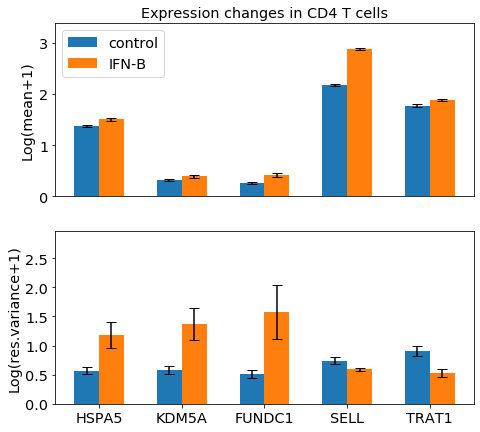

In [41]:
plot_exp_across_genes(genes_1, 'CD4 T cells', parameter_dict, ci_dict, barwidth=0.3)
plt.savefig(data_path + 'figures/cd4_across_genes_2.pdf'.format(gene), bbox_inches='tight')

### Differential expression + variability plot

In [28]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_delta_dict = pkl.load(f)

In [50]:
ct = 'CD4 T cells'
de_diff = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff']
dv_diff = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff']
de_fdr = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr']
dv_fdr = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr']

In [91]:
def pretty_print(arr):
    
    for a in arr:
        print(a + ',')

In [84]:
lower_right = adata.var.index[(de_diff > 0) & (dv_diff < 0) & sig]
upper_right = adata.var.index[(de_diff > 0) & (dv_diff > 0) & sig]
lower_left = adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig]
upper_left = adata.var.index[(de_diff < 0) & (dv_diff > 0) & sig]

In [88]:
lower_right

Index(['IFI6', 'IFI44L', 'IFI44', 'C1orf52', 'SELL', 'CMPK2', 'RSAD2',
       'EIF2AK2', 'ARHGAP25', 'TNFAIP6', 'GPR155', 'C2orf47', 'NCL', 'TRAT1',
       'LAMP3', 'ARAP2', 'TBC1D1', 'CYCS', 'GIMAP4', 'SLC38A5', 'LY6E',
       'IFIT2', 'IFIT3', 'IFIT1', 'ASCL2', 'TRIM22', 'CCDC85B', 'PARP11',
       'SLC38A2', 'OASL', 'EPSTI1', 'PPP2R5C', 'ZBP1', 'LGALS2'],
      dtype='object', name='index')

In [94]:
pretty_print(upper_left)

CD52,
S100A8,
CXCR4,
METTL21A,
VCAN,
COA1,
CLEC5A,
RAB33A,
NUDT5,
C10orf54,
B3GAT3,
CCS,
PTPRCAP,
RGCC,
THBS1,
PLEKHF1,
EMP3,
FAM118A,
IFNAR2,


In [71]:
pretty_print(adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig])

FAM159A
PRPF38B
DUSP12
MRPL55
SMC4
PPP1R2
CDKN2AIP
C9orf142
MIS18BP1
CGRRF1
MAP2K1
UQCRC2
DLGAP1-AS1
CHMP1B
BABAM1


In [53]:
sig = (de_fdr < 0.1) & (dv_fdr < 0.2)

In [1]:
plt.scatter(de_diff[sig], dv_diff[sig], s=40, color='g')
plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
plt.plot([0, 0], [-4, 2.5], '--', lw=5, color='k')
plt.plot([-3, 5], [0, 0], '--', lw=5, color='k')

plt.xlabel('Mean Log-FC');
plt.ylabel('Residual variance Log-FC')
plt.savefig(data_path + 'figures/cd4_2d_changes.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

### Pseudotime interferon stimulation analysis

In [606]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    ht_dict = pkl.load(f)

In [45]:
cd4_pt_df = pd.read_csv(data_path + 'cd4_timepoints.csv', index_col=0)
cd4_adata = adata[adata.obs.cell == 'CD4 T cells'].copy()
cd4_adata.obs['stim_tp'] = cd4_pt_df['stim_tp'].astype(str)
cd4_stim_adata = cd4_adata[cd4_adata.obs.stim == 'stim'].copy()
cd4_stim_adata.obs['stim_tp'] = cd4_stim_adata.obs['stim_tp'].replace('5', '4')

In [46]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=cd4_stim_adata, 
    group_label='stim_tp',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: 2
Computing observed moments for: 0
Computing observed moments for: 1
Computing observed moments for: 3
Computing observed moments for: 4


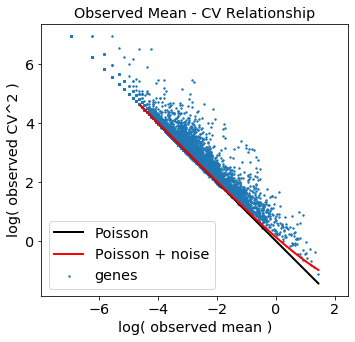

In [47]:
estimator.plot_cv_mean_curve()

In [48]:
estimator.estimate_parameters()

In [49]:
estimator.compute_confidence_intervals_1d(
    groups=estimator.groups,
    groups_to_compare=[])

Gamma RVs generated..


In [627]:
def plot_param_trajectory(gene, estimator, x_axis_width, y_axis_width):
    
    groups = [str(i) for i in range(5 if gene != 'ARL4A' else 4)] 
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    means = np.array([estimator.parameters[group]['log_mean'][gene_idx] for group in groups])
    dispersions = np.array([estimator.parameters[group]['log_residual_var'][gene_idx] for group in groups])
    
    means_ci = [estimator.parameters_confidence_intervals[group]['log_mean'][gene_idx] for group in groups]
    dispersions_ci = [estimator.parameters_confidence_intervals[group]['log_residual_var'][gene_idx] for group in groups]
    
    plt.errorbar(
        x=means, 
        y=dispersions,
        xerr=means_ci,
        yerr=dispersions_ci,
        fmt='.-',
        capsize=2,
        ecolor='k')
    plt.title(gene)

    offset=0.03
    for i, label in enumerate(groups):
        mean_offset = -0.03 if i % 2 == 0 else 0
        plt.annotate(label, (means[i] + mean_offset, dispersions[i]+dispersions_ci[i]+offset))
    
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    
    ymid = (ymin + ymax)/2
    xmid = (xmin + xmax)/2
    
    #axes.set_xlim([xmid - x_axis_width, xmid + x_axis_width])
    axes.set_ylim([ymin, ymax + 0.2])
    
    axes.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    

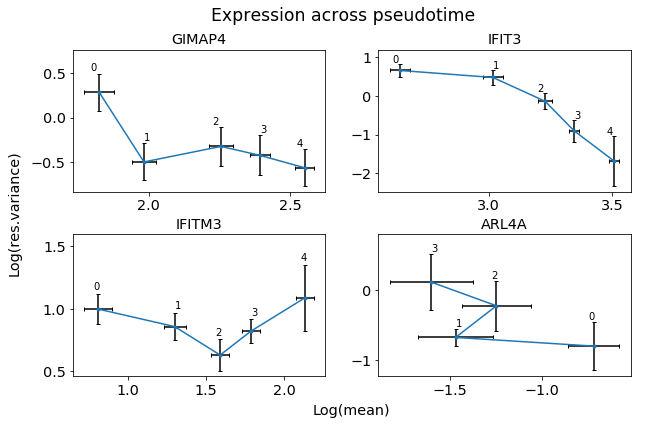

In [628]:
x_width = 0.8
y_width = 2
fig = plt.figure(figsize=(10, 6))
plt.suptitle('Expression across pseudotime')
plt.subplots_adjust(hspace=0.3, wspace=0.21)
plt.subplot(2, 2, 1)
plot_param_trajectory(
    gene='GIMAP4', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 2)
plot_param_trajectory(
    gene='IFIT3', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 3)
plot_param_trajectory(
    gene='IFITM3', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 4)
plot_param_trajectory(
    gene='ARL4A', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)

ax = fig.add_subplot(111, frameon=False);
plt.tick_params(
    which='both',
    length=0,
    labelcolor='none', 
    top='off', 
    bottom='off', 
    left='off', 
    right='off');
ax.set_xlabel('Log(mean)', labelpad=10);
ax.set_ylabel('Log(res.variance)', labelpad=25);

### TF - gene differential correlation

In [16]:
with open(data_path + 'stim_effect_1d_moments.pkl', 'rb') as f:
    moment_dict_1d = pkl.load(f)

In [17]:
with open(data_path + 'stim_effect_2d.pkl', 'rb') as f:
    dc_result = pkl.load(f)
with open(data_path + 'stim_effect_ci_2d.pkl', 'rb') as f:
    corr_ci = pkl.load(f)

In [70]:
idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']

In [71]:
genes = pd.DataFrame(
    data=list(zip(
        adata.var.index[idxs_1[gene_pair_idx[0]]], 
        adata.var.index[idxs_2[gene_pair_idx[1]]],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_pair_idx],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_pair_idx])),
    columns=['gene_1', 'gene_2', 'corr_1', 'corr_2'])

NameError: name 'gene_pair_idx' is not defined

In [ ]:
genes.sort_values('corr_2', ascending=False)

In [53]:
def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 10, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    plt.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    plt.plot(x_range, line, color=sns.color_palette()[color_order])

In [54]:
def plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, gene_1, gene_2, offset=0.1):

    idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
    idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
    
    gene_idx_1 = np.where(adata.var.index == gene_1)[0][0]
    gene_idx_2 = np.where(adata.var.index == gene_2)[0][0]
    
    df_1 = pd.DataFrame(
        adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
        columns=['gene_1', 'gene_2'])
    df_2 = pd.DataFrame(
            adata[adata.obs.cell_type == ct + ' - stim'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
            columns=['gene_1', 'gene_2'])

    count_df_1 = df_1\
        .merge(
            pd.DataFrame(df_1.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')

    count_df_2 = df_2\
        .merge(
            pd.DataFrame(df_2.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')
    
    count_df_1['size'] = count_df_1[0]
    count_df_1['log_size'] = np.sqrt((count_df_1['size']))+10

    count_df_2['size'] = count_df_2[0]
    count_df_2['log_size'] = np.sqrt((count_df_2['size']))+10
    
    y1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_2].toarray().reshape(-1) - offset
    x1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_1].toarray().reshape(-1) - offset

    y2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_2].toarray().reshape(-1) + offset
    x2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_1].toarray().reshape(-1) + offset
    
    mu_x1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_1]
    mu_y1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_2]
    mu_x2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_1]
    mu_y2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_2]

    sigma_x1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_1])
    sigma_y1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_2])
    sigma_x2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_1])
    sigma_y2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_2])

    corr_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_1 = corr_ci[ct + ' - ctrl']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_2 = corr_ci[ct + ' - stim']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    plt.scatter(x1, y1, s=count_df_1.log_size, label='control')
    
    plt.scatter(x2, y2, s=count_df_2.log_size, label='IFN-B')
    
    line_from_correlation(
        corr_1, corr_ci_1, 
        x1 + offset, y1 + offset,
        mu_x1, mu_y1, sigma_x1, sigma_y1,
        color_order=0)
    
    line_from_correlation(
        corr_2, corr_ci_2, 
        x2 - offset, y2 - offset, 
        mu_x2, mu_y2, sigma_x2, sigma_y2,
        color_order=1)
    
    plt.xlabel('{} expression'.format(gene_1))
    plt.ylabel('{} expression'.format(gene_2))
    plt.legend()
    plt.title('Relationship between {} \n and {} in {}'.format(gene_1, gene_2, ct))

In [55]:
ct = 'CD4 T cells'

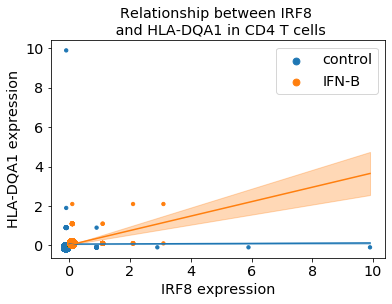

In [56]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, 'IRF8', 'HLA-DQA1', offset=0.1)

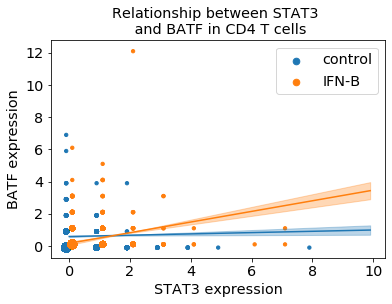

In [61]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'BATF', offset=0.1)

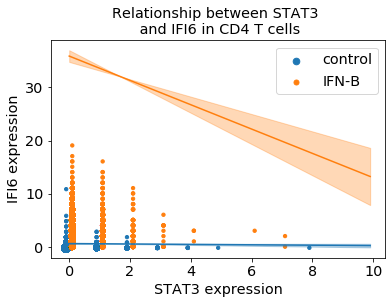

In [62]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'IFI6', offset=0.1)

### Scaling with the number of cells

In [27]:
import time

In [109]:
def one_run(N):
    
    adata_copy = adata.copy()
    sc.pp.subsample(adata_copy, n_obs=N)
    estimator = scme.SingleCellEstimator(
        adata=adata_copy,
        group_label='stim',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1)
    
    estimator.estimate_beta_sq(tolerance=3)
    estimator.estimate_parameters()
    
    start = time.time()
    imp.reload(scme)
    estimator.compute_confidence_intervals_1d(
        groups=['ctrl','stim'],
        groups_to_compare=[('ctrl', 'stim')])
    
    return time.time() - start

In [110]:
Ns = [100, 500, 1000, 2000, 3000, 5000, 10000, 20000]
more_Ns = [10000 + 1000 * i for i in range(1, 9)]

In [113]:
more_perm_times = [one_run(N) for N in more_Ns]

Computing observed moments for: ctrl
Computing observed moments for: stim


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-113-86d38b744b7e>", line 1, in <module>
    more_perm_times = [one_run(N) for N in more_Ns]
  File "<ipython-input-113-86d38b744b7e>", line 1, in <listcomp>
    more_perm_times = [one_run(N) for N in more_Ns]
  File "<ipython-input-109-67d4eb06024e>", line 19, in one_run
    groups_to_compare=[('ctrl', 'stim')])
  File "/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc/scme.py", line 409, in compute_confidence_intervals_1d
    data = self.anndata.X[cell_selector, :].toarray()
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/compressed.py", line 1024, in toarray
    out = self._process_toarray_args(order, out)
  File "/wynton/group/ye/mincheol/anaconda3/envs/sin

KeyboardInterrupt: 

In [88]:
perm_times = [one_run(N) for N in Ns]

Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..


In [42]:
times = [one_run(N) for N in Ns]

Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..


In [53]:
# Ns = [0] + Ns
# times = [0] + times

In [58]:
200/60

3.3333333333333335

In [83]:
times

[0,
 20.869556665420532,
 35.29805541038513,
 38.040297746658325,
 46.348387002944946,
 58.43357753753662,
 87.58861637115479,
 142.3105809688568,
 222.7312273979187]

In [78]:
adata_copy = adata.copy()
sc.pp.subsample(adata_copy, n_obs=20000)

In [81]:
sc.tl.rank_genes_groups(adata_copy, groupby='stim',method='wilcoxon')

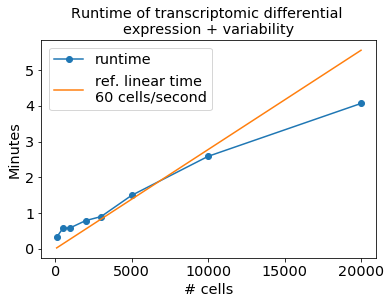

In [112]:
plt.plot(Ns, np.array(perm_times)/60, '-o', label='runtime')
plt.plot(Ns, np.array(Ns)/60/60, label='ref. linear time\n60 cells/second')
plt.legend()
plt.title('Runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/sublinear_runtime.pdf', bbox_inches='tight')

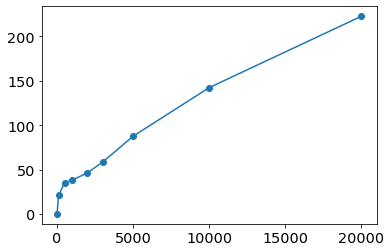

In [82]:
plt.plot(Ns, times, '-o')

#plt.plot(Ns, np.array(Ns)*times[0]/Ns[0])

In [20]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata,
    group_label='stim',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [21]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: ctrl
Computing observed moments for: stim


In [25]:
estimator.estimate_parameters()

In [153]:
ct = 'CD4 T cells'

In [ ]:
adatas

In [26]:
%%time
imp.reload(scme)
estimator.compute_confidence_intervals_1d(
    groups=['ctrl','stim'],
    groups_to_compare=[('ctrl', 'stim')])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1315, in time
    out = eval(code_2, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc/scme.py", line 409, in compute_confidence_intervals_1d
    data = self.anndata.X[cell_selector, :].toarray()
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/compressed.py", line 1035, in toarray
    csr_todense(M, N, x.indptr, x.indices, x.data, y)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has n

KeyboardInterrupt: 